<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/Exponential%20Smoothing%20and%20Holt-Winters/Exponential_Smoothing_and_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters


In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [4]:
# Load Dataset
df = pd.read_csv("weekly_customer_complaints.csv", index_col="week", parse_dates=True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [6]:
df = df.rename(columns = {'complaints' : 'y'})
df['y'] = df['y'].str.replace(',','').astype(int)
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26%,1,0,0
2018-01-08,1701,35.38%,0,0,0
2018-01-15,1711,36.22%,1,0,0
2018-01-22,1443,38.33%,1,0,0
2018-01-29,1397,36.34%,0,0,0


### DATA VISUALIZATION ###

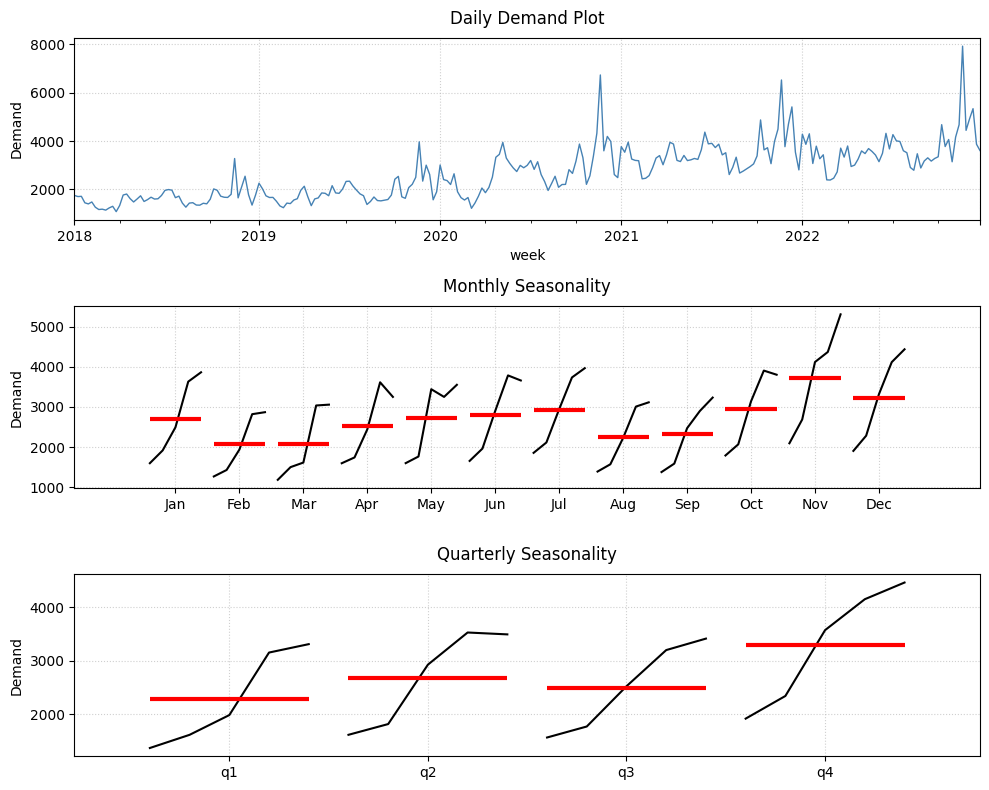

In [8]:
# Create figure with subplots
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df['y'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Daily Demand Plot', fontsize=12, pad=10)
ax1.set_ylabel('Demand', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)

# Monthly Seasonality Plot
month_plot(df['y'].resample('ME').mean(), ylabel='Demand', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Demand', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df['y'].resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Demand', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

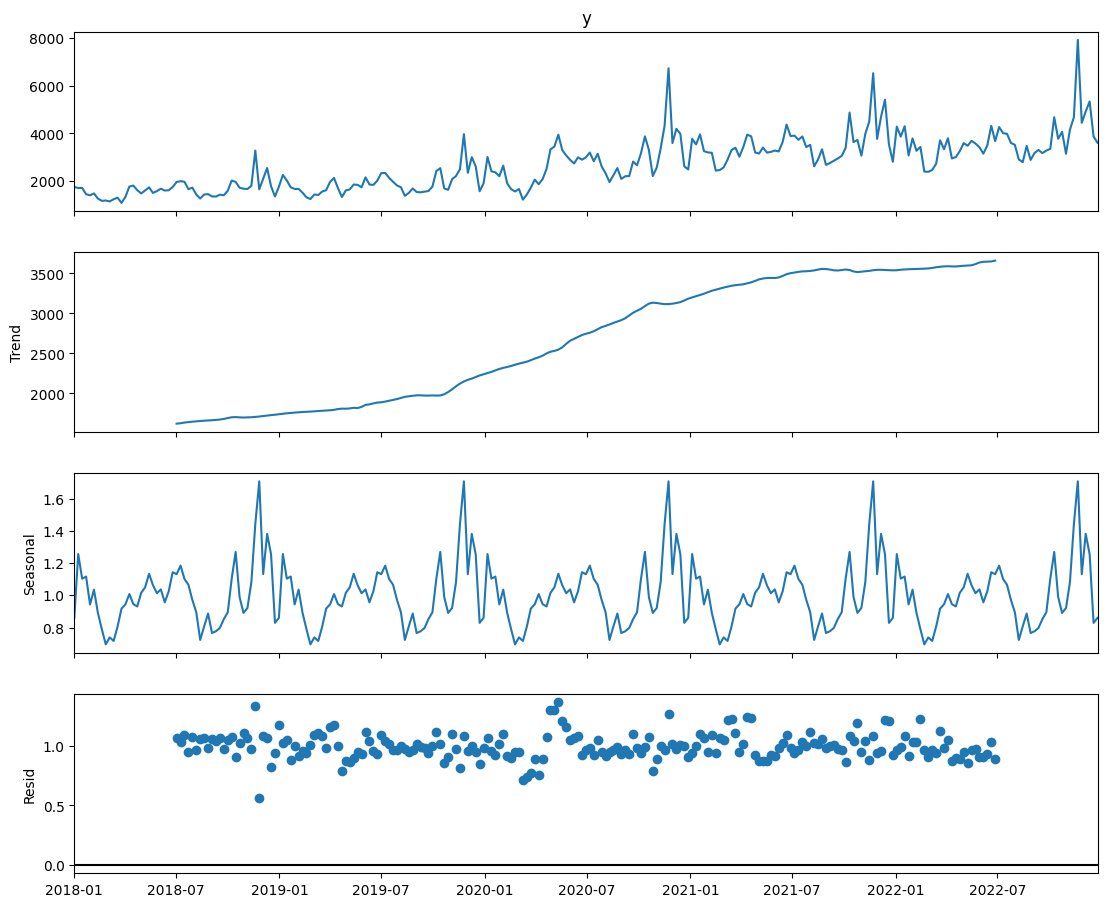

In [11]:
# Decomposition Plot
decomposition = seasonal_decompose(df['y'],
                                   model='multiplicative',
                                   period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

# 52 weeks per year

### PARTIAL AUTO-CORRELATION ###

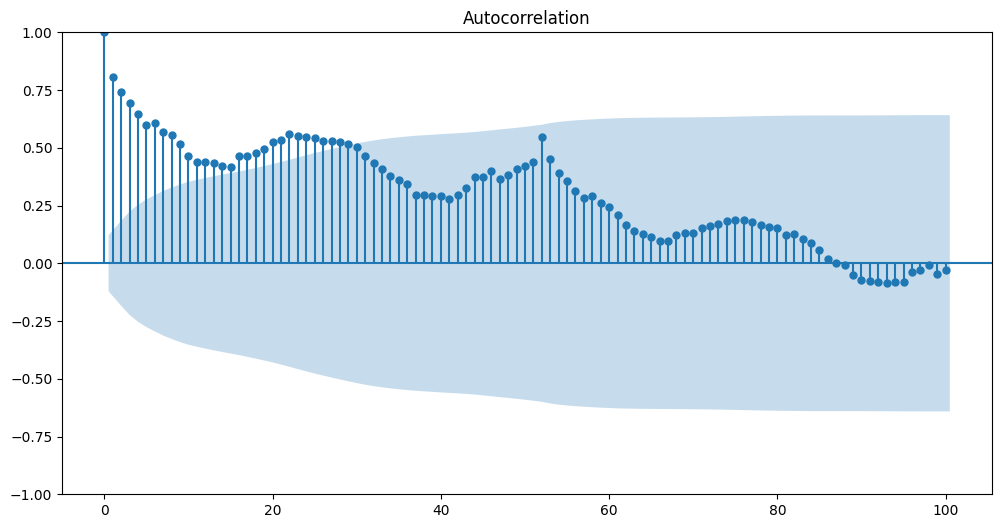

In [12]:
# ACF plot to see correlation of the series with lagged values
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['y'], lags=100, ax=ax)
plt.show()

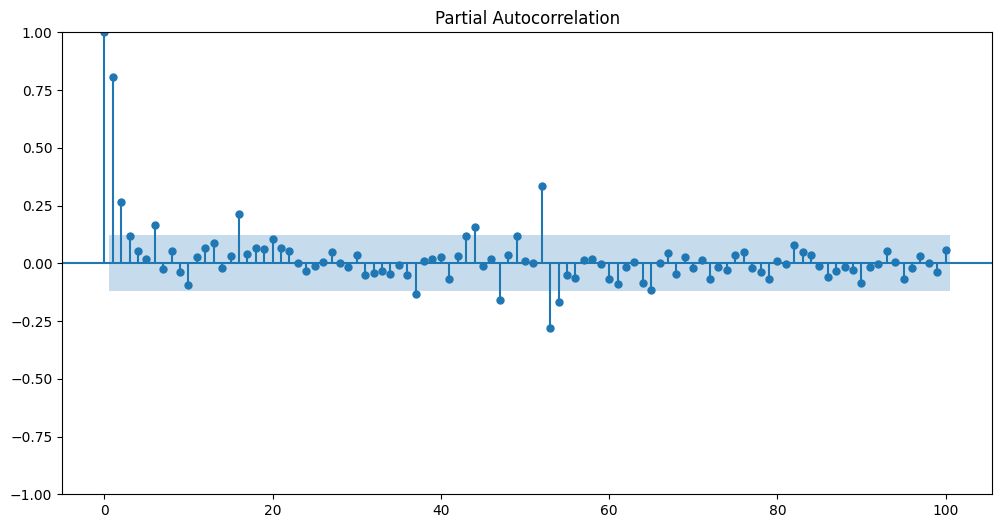

In [13]:
# PACF plot to see partial correlation (effect after removing intermediate lags)
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df['y'], lags=100, ax=ax)
plt.show()

### SETTING THE TIME-SERIES FREQUENCY ###

In [14]:
# Inspect the DateTimeIndex
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

In [15]:
# Convert the DataFrame to have weekly frequency (Mon-based).
df = df.asfreq('W-MON')
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq='W-MON')

###  TRAIN TEST SPLIT ###

In [16]:
# We want to forecast the next 13 weeks
periods = 13
train, test = df.iloc[:-periods, 0], df.iloc[-periods:, 0]

### SIMPLE EXPONENTIAL SMOOTHING ###

In [17]:
# Apply SES to train data
ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                      y   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355478.081
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Fri, 29 Aug 2025
Box-Cox:                        False   Time:                         11:50:18
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5097819                alpha                 True
initial_level              1750.0000                

In [18]:
# Compute with the initial level
train.iloc[-1] * 0.51 + 1759

np.float64(3431.29)

In [19]:
# Predictions
ses_pred = ses_model.forecast(periods)
ses_pred

,0
2022-10-03,3236.663473
2022-10-10,3236.663473
2022-10-17,3236.663473
2022-10-24,3236.663473
2022-10-31,3236.663473
2022-11-07,3236.663473
2022-11-14,3236.663473
2022-11-21,3236.663473
2022-11-28,3236.663473
2022-12-05,3236.663473


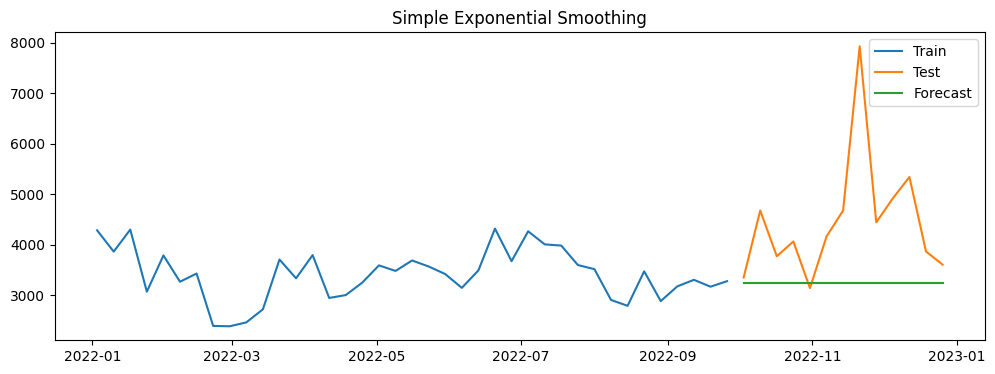

In [20]:
plt.figure(figsize = (12, 4))

# Plot the train, test and forecast data
plt.plot(train.loc['2022'], label = "Train")
plt.plot(test, label = "Test")
plt.plot(ses_pred, label = "Forecast")

# Add a title and legend to the plot
plt.title("Simple Exponential Smoothing")
plt.legend()
plt.show()

### DOUBLE EXPPONENTIAL SMOOTHING ###

In [21]:
# Double exponential smoothing model (trend="add" for additive trend)
model_double = ExponentialSmoothing(
    endog=train,
    trend="add",
    seasonal=None
).fit()
print(model_double.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       74343958.374
Optimized:                         True   AIC                           3135.474
Trend:                         Additive   BIC                           3149.528
Seasonal:                          None   AICC                          3135.823
Seasonal Periods:                  None   Date:                 Fri, 29 Aug 2025
Box-Cox:                          False   Time:                         11:51:06
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5093872                alpha                 True
smoothing_trend             0.0000

In [22]:
# Forecast with the double ES model
double_pred = model_double.forecast(periods)
double_pred

,0
2022-10-03,3248.184263
2022-10-10,3254.072668
2022-10-17,3259.961074
2022-10-24,3265.849480
2022-10-31,3271.737885
2022-11-07,3277.626291
2022-11-14,3283.514697
2022-11-21,3289.403102
2022-11-28,3295.291508
2022-12-05,3301.179913


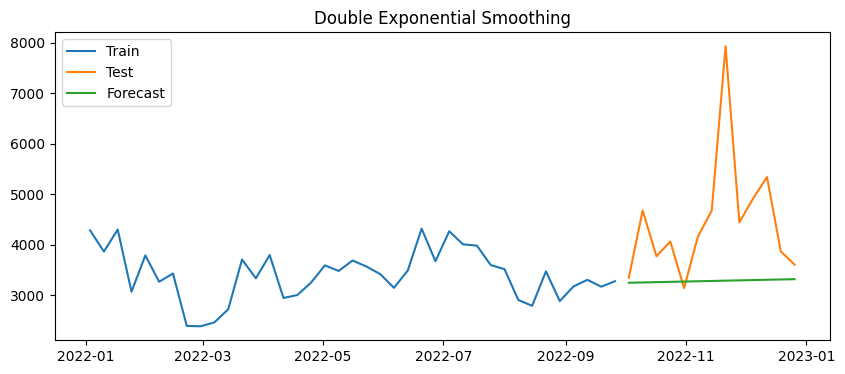

In [23]:
# Plot the train, test and forecast
plt.figure(figsize = (10, 4))

# Plot the train, test and forecast data
plt.plot(train.loc['2022'], label = "Train")
plt.plot(test, label = "Test")
plt.plot(double_pred, label = "Forecast")

# Add a title and legend to the plot
plt.title("Double Exponential Smoothing")
plt.legend()
plt.show()

### HOLT-WINTERS OR TRIPLE EXPONENTIAL SMOOTHING ###

In [25]:
# Build the Holt-Winters model with both trend and seasonality
# Using seasonal_periods=52 for weekly data, with a multiplicative season
model_holt = ExponentialSmoothing(
    endog=train,
    trend="add",
    seasonal="mul",
    seasonal_periods=52
).fit()
print(model_holt.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       21600694.698
Optimized:                         True   AIC                           2932.952
Trend:                         Additive   BIC                           3129.704
Seasonal:                Multiplicative   AICC                          2969.164
Seasonal Periods:                    52   Date:                 Fri, 29 Aug 2025
Box-Cox:                          False   Time:                         11:51:50
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2491205                alpha                 True
smoothing_trend          

In [26]:
# Forecast the next 13 weeks
holt_pred = model_holt.forecast(periods)
holt_pred[:5]

,0
2022-10-03,4041.207635
2022-10-10,5040.723320
2022-10-17,3932.012234
2022-10-24,3531.280108
2022-10-31,3441.245496


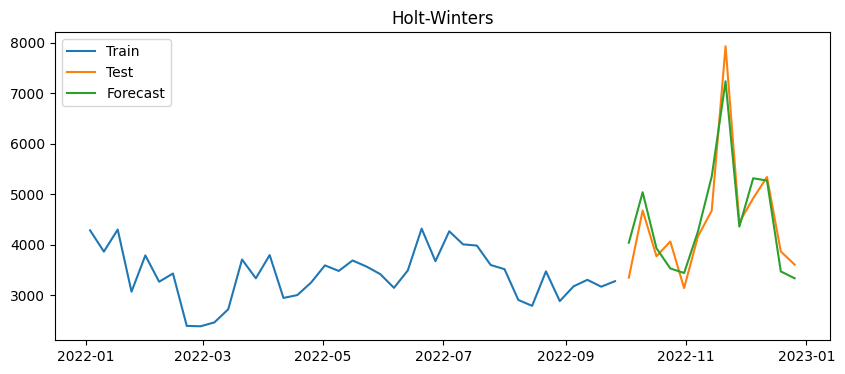

In [27]:
# Plot the Train, Test and Forecast
plt.figure(figsize = (10, 4))

# Plot the train, test and forecast
plt.plot(train.loc['2022'], label = "Train")
plt.plot(test, label = "Test")
plt.plot(holt_pred, label = "Forecast")

# Add a title and legend to the plot
plt.title("Holt-Winters")
plt.legend()
plt.show()

### MEASURING ERRORS ###

In [28]:
# Evaluate the forecast using RMSE, MAE, MAPE
rmse = root_mean_squared_error(test, holt_pred)
mae = mean_absolute_error(test, holt_pred)
mape = mean_absolute_percentage_error(test, holt_pred)
print(f"RMSE: {rmse:.0f}")
print(f"MAE: {mae:.0f}")
print(f"MAPE: {100 * mape:.1f} %")

RMSE: 425
MAE: 364
MAPE: 8.4 %


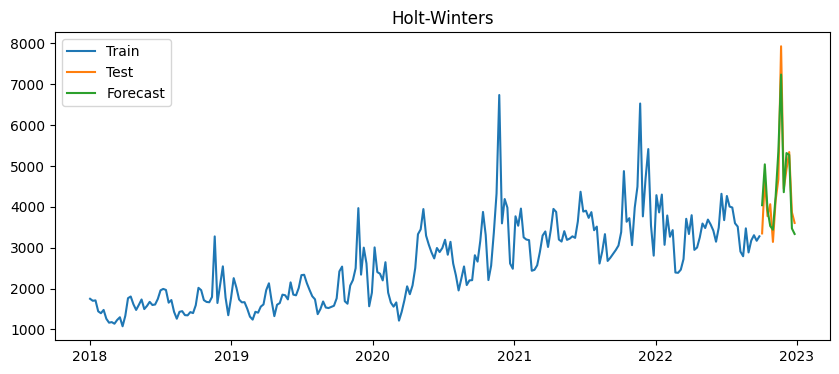

RMSE: 425
MAE: 364
MAPE: 8.4 %


In [29]:
# Function that assesses the model and visualizes the train, test and forecast
def model_assessment(train, test, predictions, chart_title = None):
  """
  Visualize and evaluate forecasts using RMSE, MAE, MAPE metrics.
  """

  # Set the chart size
  plt.figure(figsize = (10, 4))

  # Plot the train, test and forecast
  plt.plot(train, label = "Train")
  plt.plot(test, label = "Test")
  plt.plot(predictions, label = "Forecast")
  plt.title(chart_title)
  plt.legend()
  plt.show()

  # Calculate and print the RMSE, MAE, and MAPE
  rmse = root_mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)
  print(f"RMSE: {rmse:.0f}")
  print(f"MAE: {mae:.0f}")
  print(f"MAPE: {100 * mape:.1f} %")

model_assessment(train, test, holt_pred, "Holt-Winters")

### PREDICT THE FURTURE ###

In [30]:
# Explore the data
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26%,1,0,0
2018-01-08,1701,35.38%,0,0,0
2018-01-15,1711,36.22%,1,0,0
2018-01-22,1443,38.33%,1,0,0
2018-01-29,1397,36.34%,0,0,0


In [31]:
# Build a Holt-Winters model using the complete dataset
model_holt_complete = ExponentialSmoothing(
    endog=df.y,
    trend="add",
    seasonal="mul",
    seasonal_periods=52
).fit()

In [32]:
# Forecast the next 13 weeks beyond the existing data
forecast = model_holt_complete.forecast(13)
forecast[:5]

,0
2023-01-02,4965.837323
2023-01-09,4478.091513
2023-01-16,4699.515551
2023-01-23,3814.120124
2023-01-30,4242.022859


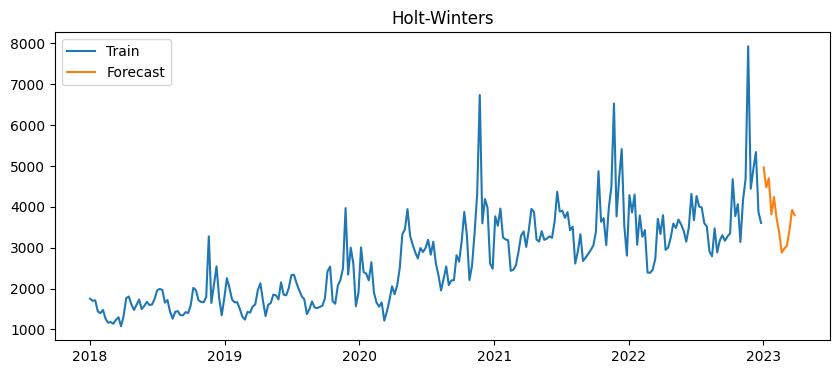

In [33]:
def plot_future(y, forecast, chart_title = None):
  """
  Plots the historical data and future forecasts on the same axis.
  """

  # Plot the training data and forecast
  plt.figure(figsize = (10, 4))

  # Plot the train, test and forecast
  plt.plot(y, label = "Train")
  plt.plot(forecast, label = "Forecast")

  # Add a title and legend to the plot
  plt.title(chart_title)
  plt.legend()
  plt.show()

# Apply the function
plot_future(df.y, forecast, "Holt-Winters")

### BITCOIN DAILY DATA ###

In [34]:
# Load daily Bitcoin price data, focusing on 'Adj Close' and rename it to 'y'
df_daily = pd.read_csv("bitcoin_price.csv", index_col="Date", parse_dates=True)['Adj Close'].rename("y")
df_daily.head()

,y
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [35]:
# Ensure the DataFrame has a daily frequency
df_daily = df_daily.asfreq('D')
df_daily.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

#### MODEL ASSESSMENT ####

In [36]:
# Splitting to train and test set
periods = 30
train, test = df_daily.iloc[:-periods], df_daily.iloc[-periods:]

In [37]:
# Holt-Winters model with multiplicative trend & seasonality, annual seasonality
model_daily = ExponentialSmoothing(
    endog=train,
    trend="mul",
    seasonal="mul",
    seasonal_periods=365
).fit()

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


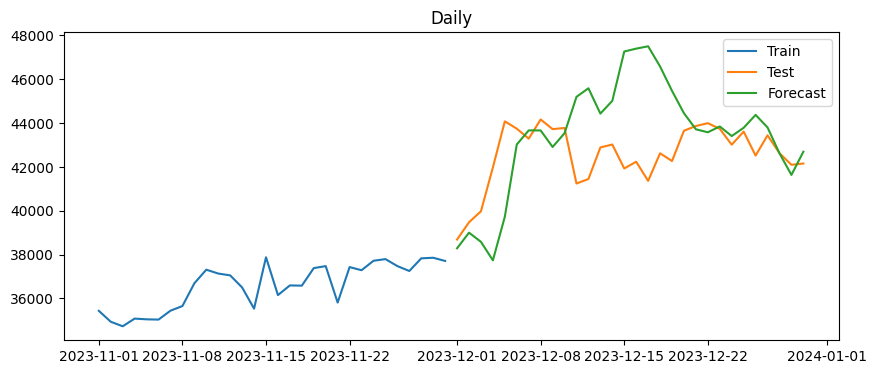

RMSE: 2607
MAE: 1807
MAPE: 4.3 %


In [38]:
# Forecast the last 30 days
daily_pred = model_daily.forecast(periods)

# Assess the model using the previously defined function
model_assessment(train['2023-11'], test, daily_pred, "Daily")